In [ ]:
!pip3 install opencv-python
# this is a bug fix, on advice from mentor Ayush

# 1 (Camera Calibration)

In [27]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt

# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
#print(objp) yields
#[[ 0.  0.  0.]
# [ 1.  0.  0.]
# [ 2.  0.  0.]
# [ 3.  0.  0.]
# ...

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/*.jpg')
#print(type(images))  images is a pyton list

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'corners_found/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        #plt.imshow(img) #cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()



In [28]:
print(objpoints[3].shape)
print(imgpoints[3].shape)


(54, 3)
(54, 1, 2)


Text(0.5,1,'Undistorted Image')

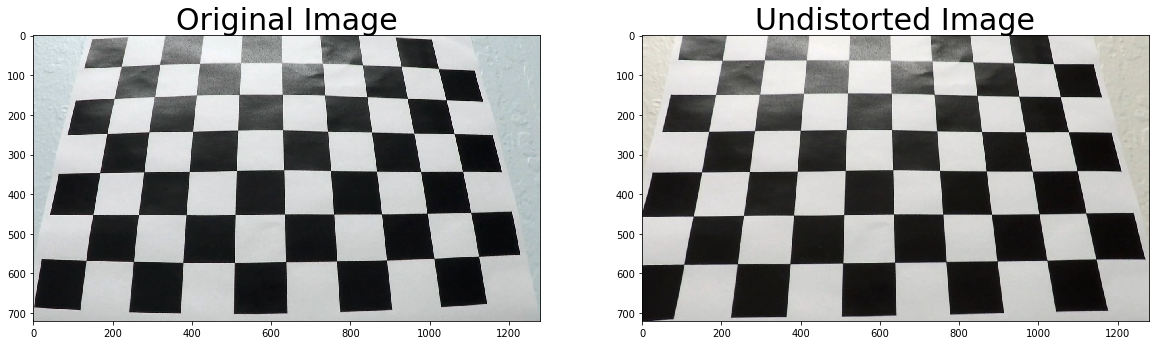

In [29]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./camera_cal/calibration3_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./camera_cal/wide_dist_pickle.p", "wb" ) )
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
#cv2.imwrite('./camera_cal/calibration3_compare.jpg',f)

# 2 (Pipeline (single images))

## 2.1 Provide an example of a distortion-corrected image.

Text(0.5,1,'Undistorted Image')

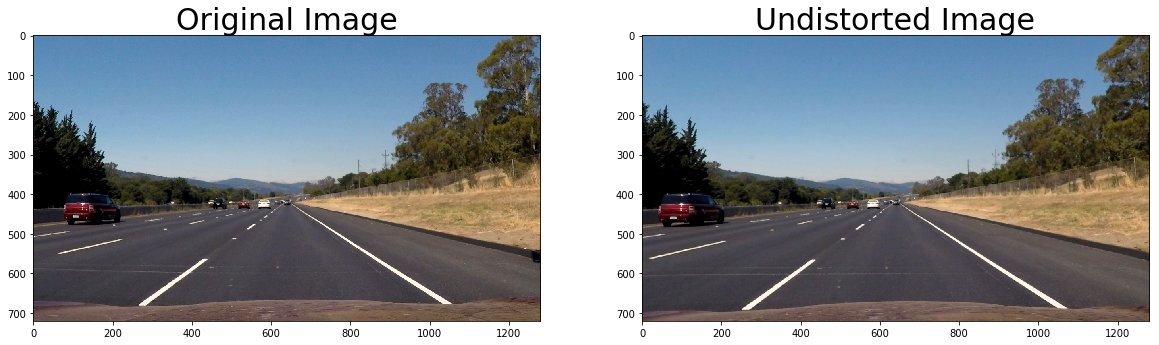

In [61]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

#reading in an image#readin 
image = mpimg.imread('test_images/test1.jpg')
#image = mpimg.imread('test_images/straight_lines1.jpg')
image = mpimg.imread('test_images/straight_lines2.jpg')
original_image=image # for further reference for plotting things

dist_pickle = pickle.load( open( "./camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

#printing out some stats and plotting

image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
#cv2.imwrite('./test_images/test1_undist.jpg',dst)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image_undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

## 2.2 Create thresholded binary image.

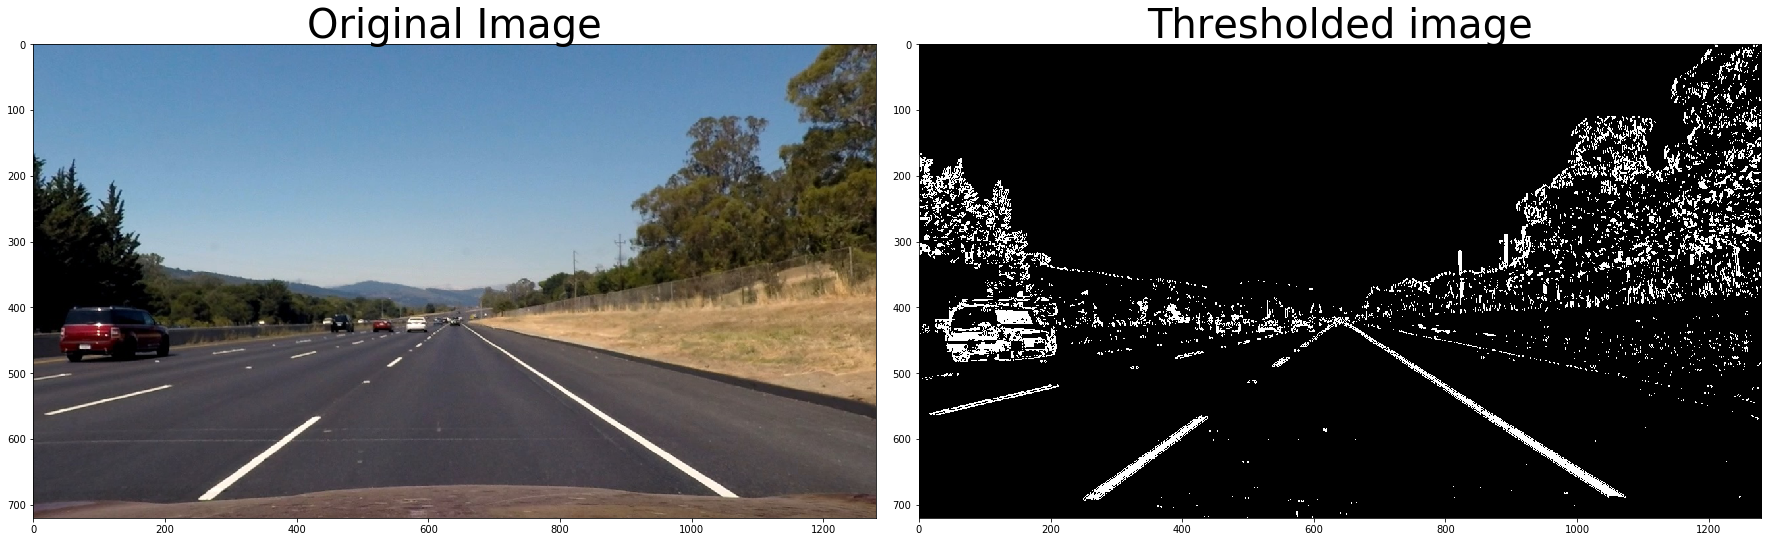

In [62]:
image = image_undistorted   # use undistorted image from last step in pipeline
original_image_undistorted=image_undistorted # for further reference for plotting things


# Edit this function to create your own pipeline.
def thresholding(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary
    
result, result_gray = thresholding(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

#ax2.set_title('Combined S channel and gradient thresholds')
#ax2.imshow(combined_binary, cmap='gray')

ax2.imshow(result_gray,cmap='gray')
ax2.set_title('Thresholded image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 2.3 Apply perspective transform.

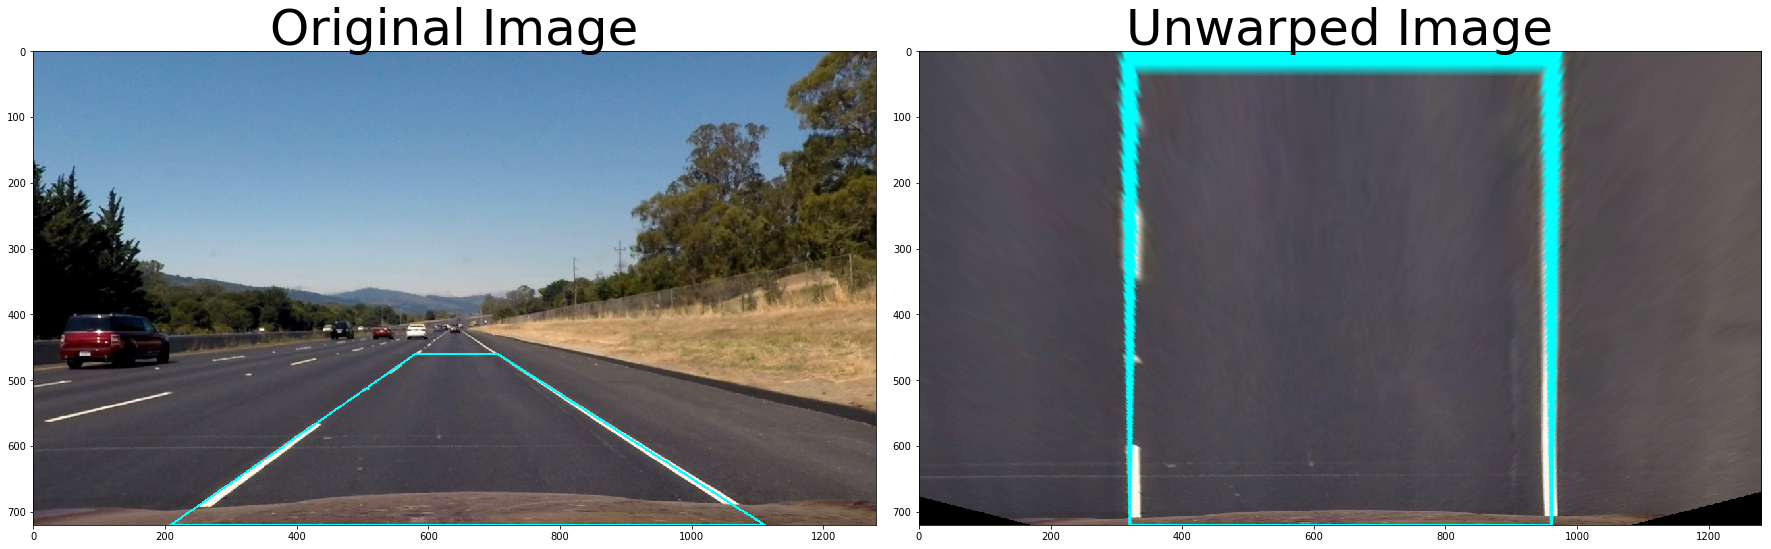

In [64]:
image = result_gray   # use undistorted and thresholded image from last step in pipeline
#original_image_undistorted

def unwarp(img):
    img_size=(img.shape[1],img.shape[0])
    src = np.float32(
     [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
     [((img_size[0] / 6) - (5)), img_size[1]],
     [(img_size[0] * 5 / 6) + 45, img_size[1]],
     [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
    dst = np.float32(
     [[(img_size[0] / 4), 0],
     [(img_size[0] / 4), img_size[1]],
     [(img_size[0] * 3 / 4), img_size[1]],
     [(img_size[0] * 3 / 4), 0]])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped=cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, src, dst
    

top_down, perspective_M, src, dst = unwarp(original_image_undistorted)

#pts = np.array([[10,5],[20,30],[70,20],[50,10]], np.int32)
#pts = pts.reshape((-1,1,2))
#cv2.polylines(img,[pts],True,(0,255,255))

#pts = np.array([[10,5],[20,30],[70,20],[50,10]], np.int32)
src = src.reshape((-1,1,2))
orig_plus_polygon=cv2.polylines(original_image_undistorted,np.int32([src]),True,(0,255,255),2)
original_image_undistorted
dst = dst.reshape((-1,1,2))
top_down_plus_polygon=cv2.polylines(top_down,np.int32([dst]),True,(0,255,255),2)

#print(perspective_M.shape)original_image_undistorted
#print(top_down.shape)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(orig_plus_polygon)
#ax1.imshow(image,cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down_plus_polygon)
ax2.set_title('Unwarped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)





In [52]:
top_down.shape

(720, 1280, 3)

In [ ]:
image.shape

In [ ]:
result_gray.shape